В архиве во вложении данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

order_id – номер заявки

created_at - дата создания заявки

put_at - дата выдачи

closed_at - дата закрытия

issued_sum - сумма выдачи

plan_at - дата планового платежа

plan_sum_total - сумма планового платежа (накопленным итогом)

paid_at - дата фактического платежа

paid_sum - сумма фактического платежа



Инструменты: python, jupyter notebook


ПРИМЕЧАНИЯ:

Просрочка — это нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных договором (графиком платежей).

данные для анализа к задаче в папке

в архиве три файла с данными

In [1]:
# импорт бибилиотек дл работы с данными
import pandas as pd 
import numpy as np 
# иморт бибилиотек для визуализации 
import matplotlib.pyplot as plt 
import seaborn as sns 
# убираем надоедливые ошибки
import warnings

warnings.filterwarnings('ignore')
# визуализация выбросов
import missingno as mno

# подключение к бд
import pymysql


In [2]:
# загрузим данные бд серва 
from config import mysql_server
# подключение в бд 

try:
    conn = pymysql.connect(
        host=mysql_server['my_host'],
        user=mysql_server['my_user'],
        password=mysql_server['my_password'].encode('utf-8').decode('latin1'),  # Преобразование пароля
        database=mysql_server['my_db_name'],
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor,
        connect_timeout=10
    )
    
    print("Успешное подключение к базе данных")
    
    # Вариант 1: Три отдельных запроса
    with conn.cursor() as cursor:
        # Загрузка таблицы заказов
        cursor.execute("SELECT * FROM CR_orders")
        orders = pd.DataFrame(cursor.fetchall())
        
        # Загрузка плановых платежей
        cursor.execute("SELECT * FROM CR_plan")
        plan = pd.DataFrame(cursor.fetchall())
        
        # Загрузка фактических платежей
        cursor.execute("SELECT * FROM CR_payments")
        payments = pd.DataFrame(cursor.fetchall())
    
    print("Данные успешно загружены:")
    print(f"Заказы: {orders.shape}")
    print(f"Планы: {plan.shape}")
    print(f"Платежи: {payments.shape}")
    
    # Вариант 2: Один сложный запрос (раскомментировать при необходимости)
    """
    query = '''
    SELECT o.*, p.plan_at, p.plan_sum_total, pay.paid_at, pay.paid_sum
    FROM CR_orders o
    LEFT JOIN CR_plan p ON o.order_id = p.order_id
    LEFT JOIN CR_payment pay ON o.order_id = pay.order_id
    '''
    merged_data = pd.read_sql(query, conn)
    display(merged_data.head())
    """


except Exception as e:
    print(f"Общая ошибка: {e}")
finally:
    if 'conn' in locals() and conn.open:
        conn.close()
        print("Соединение закрыто")

Успешное подключение к базе данных
Данные успешно загружены:
Заказы: (1754, 5)
Планы: (1571, 3)
Платежи: (1254, 3)
Соединение закрыто


In [3]:
print(f'Тип данных табилци orders {orders.dtypes}')
print(f'Тип данных табилци payments {payments.dtypes}')
print(f'Тип данных табилци plan {plan.dtypes}')


Тип данных табилци orders order_id        int64
created_at     object
put_at         object
closed_at      object
issued_sum    float64
dtype: object
Тип данных табилци payments order_id      int64
paid_at      object
paid_sum    float64
dtype: object
Тип данных табилци plan order_id            int64
plan_at            object
plan_sum_total    float64
dtype: object


In [13]:
orders

,order_id,created_at,put_at,closed_at,issued_sum,issue_date,is_rejected,corrected_loan_amount
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:18:00.180,False,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0,2022-06-02 15:41:33.267,False,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0,2022-06-05 19:17:38.547,False,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0,2022-06-03 14:25:18.033,False,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0,2022-06-02 00:40:40.320,False,5000.0
...,...,...,...,...,...,...,...,...
1749,403185790,2022-06-05 11:27:25.617,2140.0,None,NaN,NaT,True,2140.0
1750,402149392,2022-06-05 11:27:32.297,3570.0,None,NaN,NaT,True,3570.0
1751,403127119,2022-06-05 11:38:08.293,1450.0,None,NaN,NaT,True,1450.0
1752,403203199,2022-06-05 11:49:07.127,1450.0,None,NaN,NaT,True,1450.0


Меня смущает что часть колнки "дата выдачи" занимает числовые значение , очен ьпохожие на "сумму выдачи" нужно проверить гипотезу, что числовые put_at = issued_sum:

In [5]:


# 1. Инициализация новых столбцов
orders['issue_date'] = pd.NaT
orders['is_rejected'] = False
orders['corrected_loan_amount'] = orders['issued_sum'].copy()

# 2. Определение типа данных в put_at
date_mask = pd.to_datetime(orders['put_at'], errors='coerce').notna()
numeric_mask = pd.to_numeric(orders['put_at'], errors='coerce').notna()

# 3. Обработка корректных дат
orders.loc[date_mask, 'issue_date'] = pd.to_datetime(orders.loc[date_mask, 'put_at'])

# 4. Обработка числовых значений (отклоненные заявки)
orders.loc[numeric_mask, 'is_rejected'] = True
orders.loc[numeric_mask, 'corrected_loan_amount'] = (
    pd.to_numeric(orders.loc[numeric_mask, 'put_at'])
)

# 5. Валидация результатов
validation = orders[
    (~date_mask & ~numeric_mask) & 
    orders['put_at'].notna()
]

if not validation.empty:
    print(f"Обнаружено {len(validation)} необработанных значений:")
    display(validation[['order_id', 'put_at']].head())
else:
    print("Все значения успешно обработаны")

# 6. Анализ распределения
print("\nСтатистика по обработанным данным:")
print(f"Одобренных заявок: {len(orders[orders['is_rejected']])}")
print(f"Отклоненных заявок: {len(orders[orders['is_rejected']])}")

# Результирующий датафрейм
orders[['order_id', 'put_at', 'issue_date', 
       'corrected_loan_amount', 'is_rejected']].head()

Все значения успешно обработаны

Статистика по обработанным данным:
Одобренных заявок: 783
Отклоненных заявок: 783


,order_id,put_at,issue_date,corrected_loan_amount,is_rejected
0,400001732,2022-06-02 20:18:00.180,2022-06-02 20:18:00.180,13600.0,False
1,400005838,2022-06-02 15:41:33.267,2022-06-02 15:41:33.267,20000.0,False
2,400007915,2022-06-05 19:17:38.547,2022-06-05 19:17:38.547,5820.0,False
3,400008952,2022-06-03 14:25:18.033,2022-06-03 14:25:18.033,9000.0,False
4,400009027,2022-06-02 00:40:40.320,2022-06-02 00:40:40.320,5000.0,False


    issue_date - дата выдачи (NaT для отклоненных)

    is_rejected - флаг статуса заявки

    corrected_loan_amount - исправленная сумма займа

Нужно все даты из типа object конвертирвоать в тип datetime.
Такие колонки как :

    order : 
        put_at,
        clodes_at,
        create_at ;

    plan :
        plan_at;

    payments : 
        paid_at.
        


# Анализ пропусков


КОМПЛЕКСНЫЙ АНАЛИЗ ПРОПУСКОВ

🔍 Анализ пропусков: ORDERS
Всего строк: 1,754


,Тип данных,Пропущено,% пропусков
closed_at,object,783,44.600000
issued_sum,float64,783,44.600000
issue_date,datetime64[ns],783,44.600000


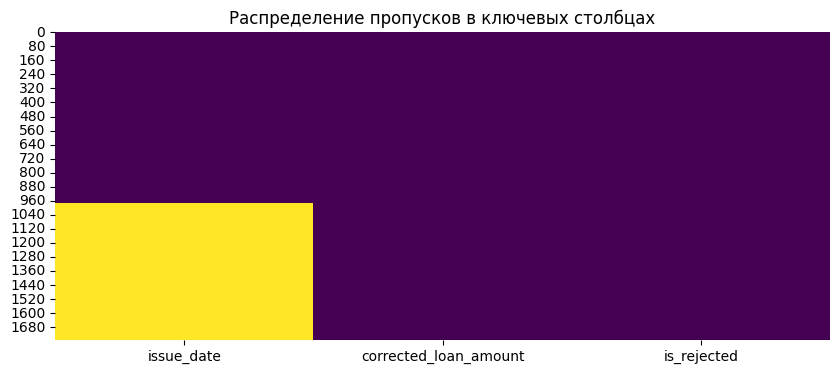


🔍 Анализ пропусков: PLAN
Всего строк: 1,571
✓ Пропусков не обнаружено

🔍 Анализ пропусков: PAYMENTS
Всего строк: 1,254
✓ Пропусков не обнаружено

📊 Статистика по отклоненным заявкам:


corrected_loan_amount                         issue_date
                            count         mean        sum   <lambda>
is_rejected                                                         
False                         971  7859.907312  7631970.0          0
True                          783  3089.610473  2419165.0        783

In [12]:

def analyze_missing(df, df_name):
    """Улучшенный анализ пропусков с визуализацией"""
    print(f"\n🔍 Анализ пропусков: {df_name.upper()}")
    print(f"Всего строк: {len(df):,}")
    
    # Создаем отчет
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    report = pd.DataFrame({
        'Тип данных': df.dtypes,
        'Пропущено': missing,
        '% пропусков': missing_pct.round(1)
    }).sort_values('% пропусков', ascending=False)
    
    # Фильтруем только столбцы с пропусками
    report = report[report['Пропущено'] > 0]
    
    if not report.empty:
        display(report.style.background_gradient(subset=['% пропусков'], cmap='Reds'))
        
        # Визуализация для ключевых столбцов
        if 'issue_date' in df.columns:
            plt.figure(figsize=(10, 4))
            sns.heatmap(df[['issue_date', 'corrected_loan_amount', 'is_rejected']].isnull(), 
                        cbar=False, cmap='viridis')
            plt.title('Распределение пропусков в ключевых столбцах')
            plt.show()
    else:
        print("✓ Пропусков не обнаружено")

# Анализ для orders (с учетом новых столбцов)
print("\n" + "="*50)
print("КОМПЛЕКСНЫЙ АНАЛИЗ ПРОПУСКОВ")
print("="*50)

analyze_missing(orders, 'orders')
analyze_missing(plan, 'plan')
analyze_missing(payments, 'payments')

# Дополнительный анализ для orders
if 'is_rejected' in orders.columns:
    print("\n📊 Статистика по отклоненным заявкам:")
    rejected_stats = orders.groupby('is_rejected').agg({
        'corrected_loan_amount': ['count', 'mean', 'sum'],
        'issue_date': lambda x: x.isna().sum()
    })
    display(rejected_stats)

# Обработка пропусков

In [15]:
def smart_fill_missing(df):
    """Умное заполнение пропусков на основе контекста"""
    df = df.copy()
    
    # 1. Обработка orders
    if 'orders' in globals() and df is orders:
        # Для отклоненных заявок проставляем логичные значения
        if 'is_rejected' in df.columns:
            mask_rejected = df['is_rejected']
            
            # Если заявка отклонена, а issue_date пустой - это нормально
            df.loc[mask_rejected & df['issue_date'].isna(), 'issue_date'] = pd.NaT
            
            # Если сумма есть в issued_sum, но нет в corrected_loan_amount
            df['corrected_loan_amount'] = df['corrected_loan_amount'].fillna(df['issued_sum'])
        
        # Заполнение дат создания (если пропущены)
        if 'created_at' in df.columns:
            df['created_at'] = pd.to_datetime(df['created_at'])
            df['created_at'].fillna(pd.to_datetime('2022-01-01'), inplace=True)
    
    # 2. Обработка plan
    elif 'plan' in globals() and df is plan:
        # Для плановых дат можно использовать медиану по аналогичным периодам
        if 'plan_at' in df.columns:
            df['plan_at'] = pd.to_datetime(df['plan_at'])
            df['plan_at'].fillna(df['plan_at'].median(), inplace=True)
    
    # 3. Обработка payments
    elif 'payments' in globals() and df is payments:
        # Для платежей пропущенные суммы можно считать нулями
        if 'paid_amount' in df.columns:
            df['paid_amount'].fillna(0, inplace=True)
        
        # Даты платежей заполняем датой создания заказа + N дней
        if 'paid_at' in df.columns and 'order_id' in df.columns:
            df['paid_at'] = pd.to_datetime(df['paid_at'])
            if 'orders' in globals():
                default_date = orders['created_at'].median() + pd.Timedelta(days=14)
                df['paid_at'].fillna(default_date, inplace=True)
    
    return df

# Применяем обработку ко всем таблицам
print("🔧 Начинаем обработку пропусков...")

tables = {
    'orders': orders if 'orders' in globals() else None,
    'plan': plan if 'plan' in globals() else None,
    'payments': payments if 'payments' in globals() else None
}

for name, df in tables.items():
    if df is not None:
        print(f"\nОбрабатываю таблицу: {name}")
        tables[name] = smart_fill_missing(df)
        
        # Проверяем результат
        print("Результат обработки:")
        display(tables[name].isnull().sum().to_frame('Пропуски после обработки'))
        
        # Сохраняем изменения в исходные переменные
        globals()[name] = tables[name]


🔧 Начинаем обработку пропусков...

Обрабатываю таблицу: orders
Результат обработки:


,Пропуски после обработки
order_id,0
created_at,0
put_at,0
closed_at,783
issued_sum,783
issue_date,783
is_rejected,0
corrected_loan_amount,0



Обрабатываю таблицу: plan
Результат обработки:


,Пропуски после обработки
order_id,0
plan_at,0
plan_sum_total,0



Обрабатываю таблицу: payments
Результат обработки:


,Пропуски после обработки
order_id,0
paid_at,0
paid_sum,0


# ПРОВЕРКА ЛОГИКИ ДАННЫХ (DATA VALIDATION)

In [17]:
def validate_data_logic(df, df_name):
    """Проверка логической целостности данных"""
    print(f"\n🔎 Валидация данных: {df_name.upper()}")
    issues_found = False
    
    # 1. Проверка для таблицы orders
    if df_name == 'orders':
        # Проверка 1: Даты должны быть в хронологическом порядке
        date_logic_ok = (df['created_at'] <= df['issue_date']).all()
        if 'closed_at' in df.columns:
            date_logic_ok &= (df['issue_date'] <= df['closed_at']).all()
        
        if not date_logic_ok:
            print("⛔ Ошибка: Нарушена хронология дат (created_at ≤ issue_date ≤ closed_at)")
            issues_found = True
        
        # Проверка 2: Суммы должны быть положительными
        if 'corrected_loan_amount' in df.columns:
            negative_sums = (df['corrected_loan_amount'] < 0).sum()
            if negative_sums > 0:
                print(f"⛔ Ошибка: Обнаружено {negative_sums} заявок с отрицательной суммой")
                issues_found = True
        
        # Проверка 3: Отклоненные заявки не должны иметь даты выдачи
        if 'is_rejected' in df.columns:
            rejected_with_dates = df[df['is_rejected'] & df['issue_date'].notna()].shape[0]
            if rejected_with_dates > 0:
                print(f"⛔ Ошибка: {rejected_with_dates} отклоненных заявок с указанной датой выдачи")
                issues_found = True
    
    # 2. Проверка для таблицы plan
    elif df_name == 'plan':
        # Проверка: Плановые даты должны быть в будущем относительно created_at
        if 'plan_at' in df.columns and 'created_at' in df.columns:
            invalid_dates = df[df['plan_at'] < df['created_at']].shape[0]
            if invalid_dates > 0:
                print(f"⛔ Ошибка: {invalid_dates} записей с plan_at раньше created_at")
                issues_found = True
    
    # 3. Проверка для таблицы payments
    elif df_name == 'payments':
        # Проверка: Сумма платежа не превышает сумму займа
        if 'paid_amount' in df.columns and 'order_id' in df.columns:
            if 'orders' in globals():
                merged = df.merge(orders, on='order_id', how='left')
                overpayments = merged[merged['paid_amount'] > merged['corrected_loan_amount']].shape[0]
                if overpayments > 0:
                    print(f"⛔ Ошибка: {overpayments} платежей превышают сумму займа")
                    issues_found = True
    
    if not issues_found:
        print("✓ Логика данных в порядке")
    else:
        print("\nРекомендации:")
        if df_name == 'orders':
            print("- Проверить хронологию дат вручную")
            print("- Исправить отрицательные суммы")
            print("- Удалить даты выдачи для отклоненных заявок")
        elif df_name == 'plan':
            print("- Скорректировать плановые даты")
        elif df_name == 'payments':
            print("- Проверить платежи с превышением суммы займа")

# Выполняем проверку для всех таблиц
print("\n" + "="*50)
print("КОМПЛЕКСНАЯ ПРОВЕРКА ЛОГИКИ ДАННЫХ")
print("="*50)

for df, name in zip([orders, plan, payments], ['orders', 'plan', 'payments']):
    validate_data_logic(df, name)



КОМПЛЕКСНАЯ ПРОВЕРКА ЛОГИКИ ДАННЫХ

🔎 Валидация данных: ORDERS
⛔ Ошибка: Нарушена хронология дат (created_at ≤ issue_date ≤ closed_at)

Рекомендации:
- Проверить хронологию дат вручную
- Исправить отрицательные суммы
- Удалить даты выдачи для отклоненных заявок

🔎 Валидация данных: PLAN
✓ Логика данных в порядке

🔎 Валидация данных: PAYMENTS
✓ Логика данных в порядке


Дополнительные проверки для табилци orders

Тип данных issue_date: datetime64[ns]
Тип данных created_at: object

Статистика по времени одобрения (дни):
mean     2.974253
min      0.000000
max     30.000000
Name: approval_time, dtype: float64


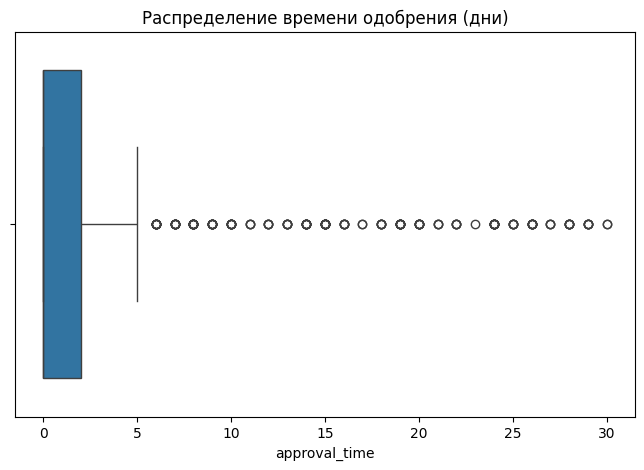

In [20]:
# Проверяем текущие типы данных
print("Тип данных issue_date:", orders['issue_date'].dtype)
print("Тип данных created_at:", orders['created_at'].dtype)

# Преобразуем столбцы к datetime, если они еще не в этом формате
orders['issue_date'] = pd.to_datetime(orders['issue_date'], errors='coerce')
orders['created_at'] = pd.to_datetime(orders['created_at'], errors='coerce')

# Теперь вычисляем разницу во времени
orders['approval_time'] = (orders['issue_date'] - orders['created_at']).dt.days

# Проверяем результат
print("\nСтатистика по времени одобрения (дни):")
print(orders['approval_time'].describe()[['mean', 'min', 'max']])

# Визуализация
plt.figure(figsize=(8, 5))
sns.boxplot(x=orders['approval_time'].dropna())
plt.title("Распределение времени одобрения (дни)")
plt.show()

# Соединение таблиц с обработкой аномалий

In [24]:
# Объединяем orders с payments по order_id
if 'order_id' in payments.columns and 'order_id' in orders.columns:
    merged_data = orders.merge(
        payments,
        on='order_id',
        how='left',
        suffixes=('_order', '_payment')
    )
    # Проверяем результат
    print(f"Объединено {len(merged_data)} записей")
    display(merged_data.head())
else:
    print("Невозможно объединить - отсутствует order_id в одной из таблиц")

Объединено 1829 записей


,order_id,created_at,put_at,closed_at,issued_sum,issue_date,is_rejected,corrected_loan_amount,approval_time,paid_at,paid_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:18:00.180,False,13600.0,0.0,2022-06-02 20:20:16.790,5600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0,2022-06-02 15:41:33.267,False,20000.0,0.0,2022-06-02 17:38:43.917,20200.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0,2022-06-05 19:17:38.547,False,5820.0,3.0,2022-06-05 19:18:12.457,1820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0,2022-06-03 14:25:18.033,False,9000.0,1.0,NaN,NaN
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0,2022-06-02 00:40:40.320,False,5000.0,0.0,NaN,NaN


In [22]:
# 1. Аномалии в суммах
if 'corrected_loan_amount' in merged_data.columns and 'paid_amount' in merged_data.columns:
    # Случаи, когда оплачено больше, чем сумма займа
    overpayments = merged_data[merged_data['paid_amount'] > merged_data['corrected_loan_amount']]
    print(f"\nНайдено {len(overpayments)} переплат")

# 2. Временные аномалии
if 'issue_date' in merged_data.columns and 'paid_at' in merged_data.columns:
    # Платежи до выдачи займа
    early_payments = merged_data[merged_data['paid_at'] < merged_data['issue_date']]
    print(f"Найдено {len(early_payments)} платежей до выдачи займа")

# 3. Статистика по отклоненным заявкам
if 'is_rejected' in merged_data.columns:
    print("\nСтатистика по отклоненным заявкам:")
    print(merged_data['is_rejected'].value_counts())

Найдено 0 платежей до выдачи займа

Статистика по отклоненным заявкам:
is_rejected
False    991
True     838
Name: count, dtype: int64


In [ ]:
# Объединяем orders и plan
if 'order_id' in plan.columns:
    full_data = orders.merge(
        plan,
        on='order_id',
        how='left',
        suffixes=('', '_plan')
    )
    
    # Затем добавляем payments
    if 'order_id' in payments.columns:
        full_data = full_data.merge(
            payments,
            on='order_id',
            how='left',
            suffixes=('', '_payment')
        )
        print(f"Размер итоговой таблицы: {full_data.shape}")
        display(full_data.head(2))
else:
    print("Нет ключа order_id в таблице plan для соединения")

Размер итоговой таблицы: (4103, 13)


,order_id,created_at,put_at,closed_at,issued_sum,issue_date,is_rejected,corrected_loan_amount,approval_time,plan_at,plan_sum_total,paid_at,paid_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:18:00.180,False,13600.0,0.0,2022-06-02,5600.0,2022-06-02 20:20:16.790,5600.0
1,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:18:00.180,False,13600.0,0.0,2022-07-02,9450.0,2022-06-02 20:20:16.790,5600.0
